<a href="https://colab.research.google.com/github/jhsung7/flightProj/blob/main/1.Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # Install plotly if not already installed
# %pip install plotly
# %pip install matplotlib
# %pip install nbformat
# %pip install seaborn
# %pip install networkx

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import plotly.express as px

Load and view dataset

In [ ]:
df = pd.read_csv("/Users/jh/Desktop/flightProj/data/flights_sample_3m.csv", encoding="utf-8")
# df = pd.read_csv("../data/flights_sample_3m.csv", encoding="utf-8")
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
df.shape

(3000000, 32)

In [5]:
df.columns

Index(['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE',
       'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER',
       'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
       'DELAY_DUE_LATE_AIRCRAFT'],
      dtype='object')

In [6]:
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN


## 1. Preprocessing

In [7]:
# Convert date column to datetime format
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], format='%Y-%m-%d')

# Convert selected columns to numeric (e.g., delay times, times, distance)
num_cols = [
    'DEP_DELAY', 'ARR_DELAY', 'CRS_DEP_TIME', 'DEP_TIME', 'TAXI_OUT',
    'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME',
    'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT'
]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove canceled flights and rows with missing delay information
df = df[df['CANCELLED'] != 1]
df = df.dropna(subset=['DEP_DELAY', 'ARR_DELAY'])

# Create time-based features
df['hour'] = (df['CRS_DEP_TIME'] // 100).astype('Int64')   # Scheduled departure hour (0–23)
df['dayofweek'] = df['FL_DATE'].dt.dayofweek               # Day of the week (Monday=0, Sunday=6)
df['month'] = df['FL_DATE'].dt.month                       # Month (1–12)

# Show a sample of the cleaned data
print("✅ Data loaded and cleaned. Sample:")
print(df[['FL_DATE', 'AIRLINE', 'FL_NUMBER', 'ORIGIN', 'DEST', 'DEP_DELAY', 'ARR_DELAY']].head())
print(f"\nTotal number of rows: {len(df)}")


✅ Data loaded and cleaned. Sample:
     FL_DATE                AIRLINE  FL_NUMBER ORIGIN DEST  DEP_DELAY  \
0 2019-01-09  United Air Lines Inc.       1562    FLL  EWR       -4.0   
1 2022-11-19   Delta Air Lines Inc.       1149    MSP  SEA       -6.0   
2 2022-07-22  United Air Lines Inc.        459    DEN  MSP        6.0   
3 2023-03-06   Delta Air Lines Inc.       2295    MSP  SFO       -1.0   
4 2020-02-23       Spirit Air Lines        407    MCO  DFW       -2.0   

   ARR_DELAY  
0      -14.0  
1       -5.0  
2        0.0  
3       24.0  
4       -1.0  

Total number of rows: 2913802


## 2. EDA

### 2.1 Basic Statistics

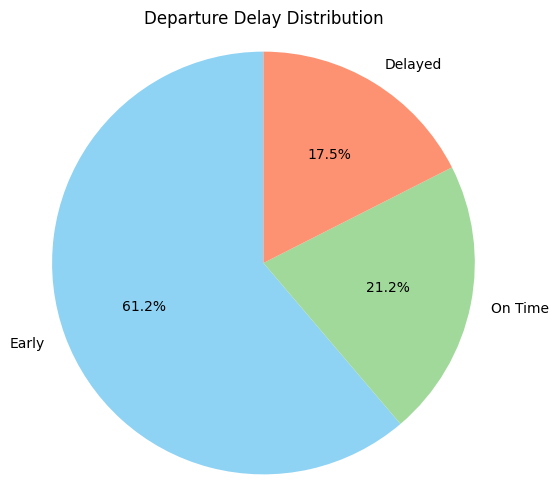

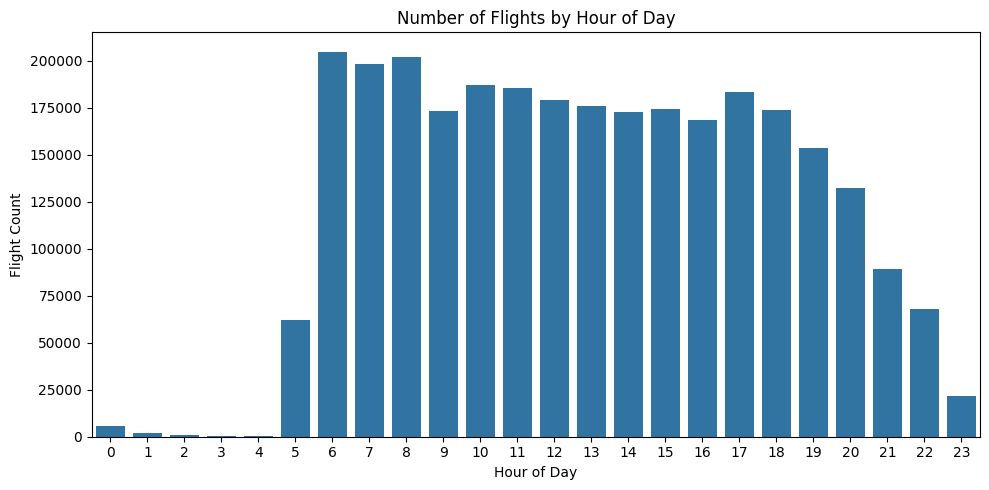

In [8]:
# 1. Pie chart of flight delay distribution
# Define categories
conditions = [
    (df['DEP_DELAY'] < 0),              # Early departure
    (df['DEP_DELAY'] >= 0) & (df['DEP_DELAY'] <= 15), # On-time departure
    (df['DEP_DELAY'] > 15)              # Delayed departure
]
labels = ['Early', 'On Time', 'Delayed']

# Count occurrences
counts = [condition.sum() for condition in conditions]

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#8fd3f4', '#a1d99b', '#fc9272'])
plt.title('Departure Delay Distribution')
plt.axis('equal') 
plt.show()

# 2. Number of flights by hour of the day
flight_counts = df['hour'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=flight_counts.index, y=flight_counts.values)
plt.title('Number of Flights by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Flight Count')
plt.tight_layout()
plt.show()

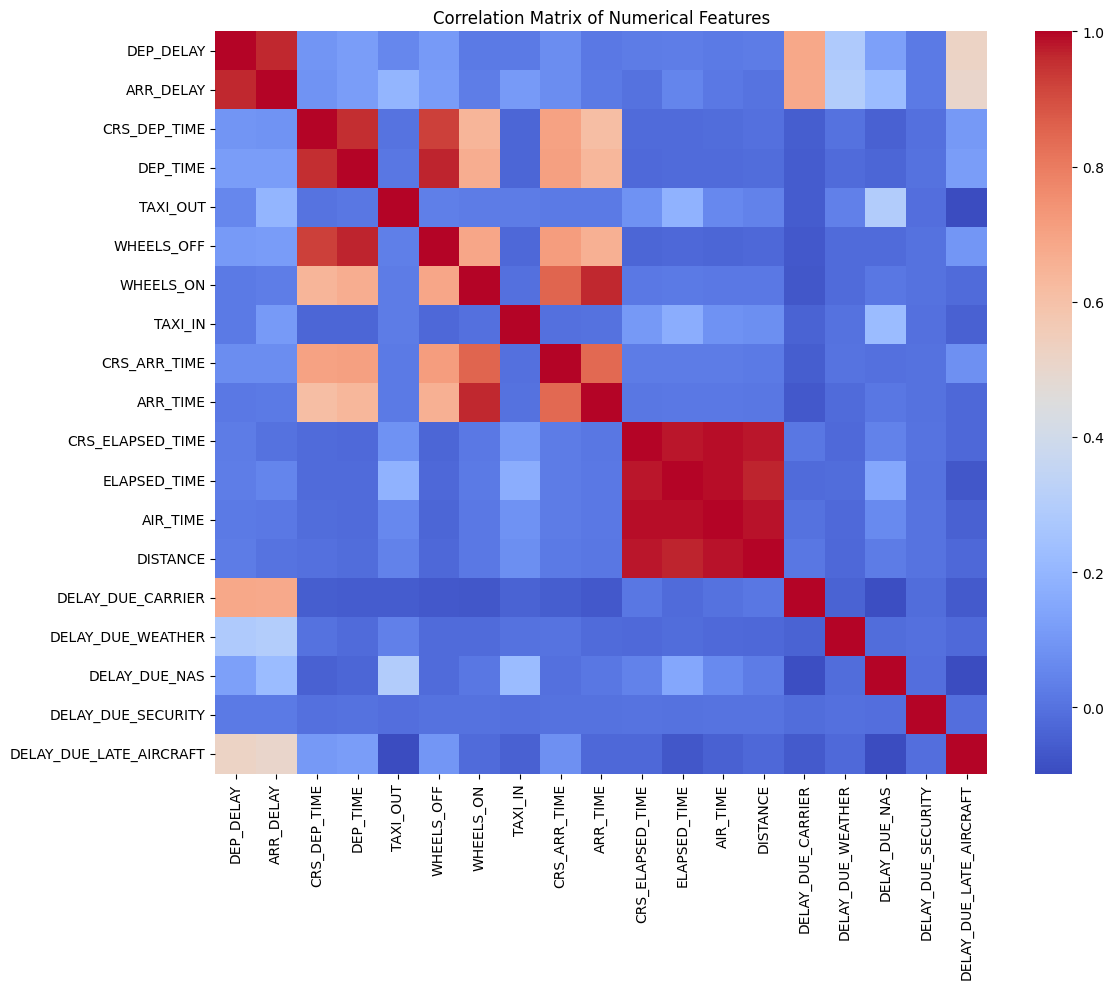

In [9]:
# Correlation matrix between numerical features
numeric_cols = [
    'DEP_DELAY', 'ARR_DELAY', 'CRS_DEP_TIME', 'DEP_TIME', 'TAXI_OUT',
    'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME',
    'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT'
]
corr = df[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

### 2.2 Time context Analysis

/var/folders/2x/7pj0tb_n6z54nzs162j3t19m0000gn/T/ipykernel_41484/72423020.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='hour', y='DEP_DELAY', estimator='mean', ci=None)


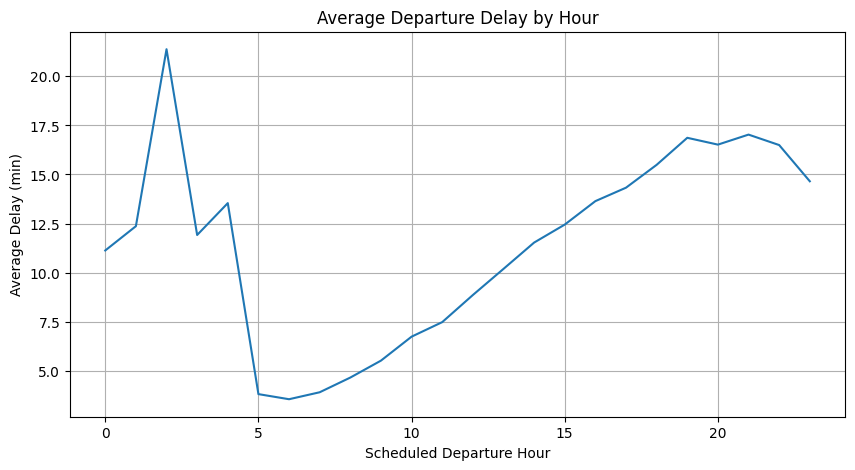

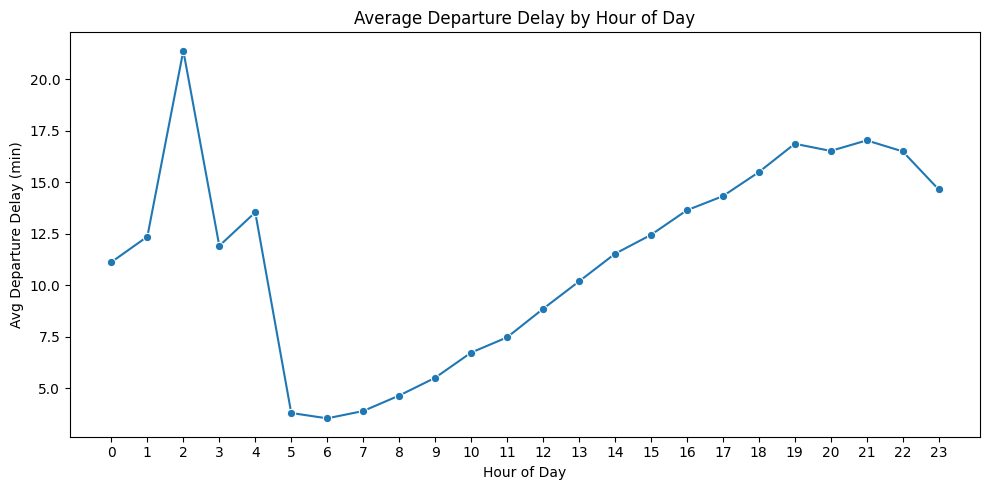

/var/folders/2x/7pj0tb_n6z54nzs162j3t19m0000gn/T/ipykernel_41484/72423020.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='dayofweek', y='DEP_DELAY', estimator='mean', ci=None)


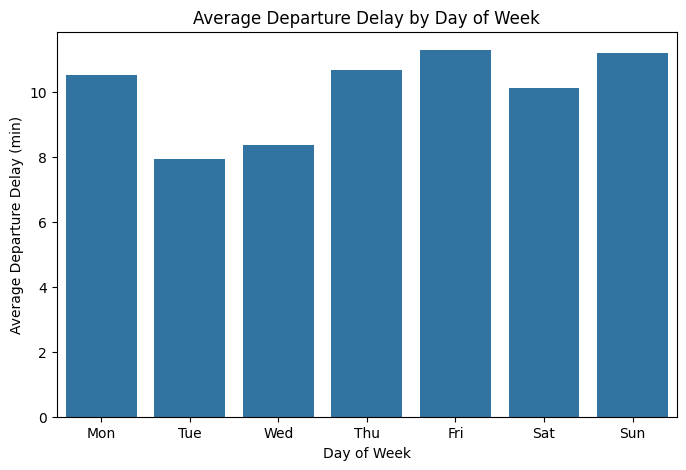

<Figure size 1000x500 with 0 Axes>

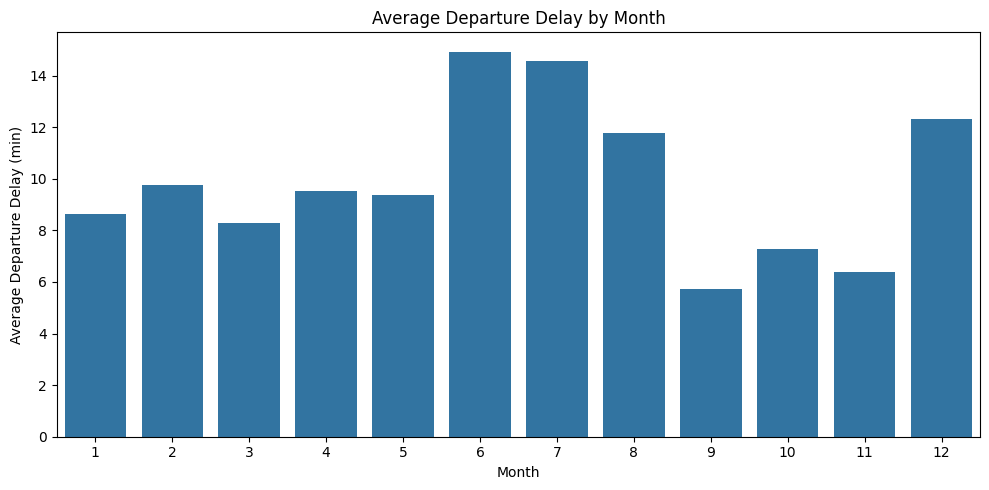

In [10]:
# 1. Average departure delay by hour of day
plt.figure(figsize=(10,5))
sns.lineplot(data=df, x='hour', y='DEP_DELAY', estimator='mean', ci=None)
plt.title('Average Departure Delay by Hour')
plt.xlabel('Scheduled Departure Hour')
plt.ylabel('Average Delay (min)')
plt.grid(True)
plt.show()

# 2. 
df['dep_hour'] = (df['CRS_DEP_TIME'] // 100).astype('Int64')
hourly_delay = df.groupby('dep_hour')['DEP_DELAY'].mean()
plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_delay.index, y=hourly_delay.values, marker='o')
plt.title('Average Departure Delay by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Avg Departure Delay (min)')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# 2. Average departure delay by day of the week
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='dayofweek', y='DEP_DELAY', estimator='mean', ci=None)
plt.title('Average Departure Delay by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Departure Delay (min)')
plt.xticks(ticks=np.arange(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

# 3. Average departure delay by month
plt.figure(figsize=(10,5))
monthly_delay = df.groupby(df['FL_DATE'].dt.month)['DEP_DELAY'].mean()
plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_delay.index, y=monthly_delay.values)
plt.title('Average Departure Delay by Month')
plt.xlabel('Month')
plt.ylabel('Average Departure Delay (min)')
plt.tight_layout()
plt.show()

### 2.3 Spatial Analysis

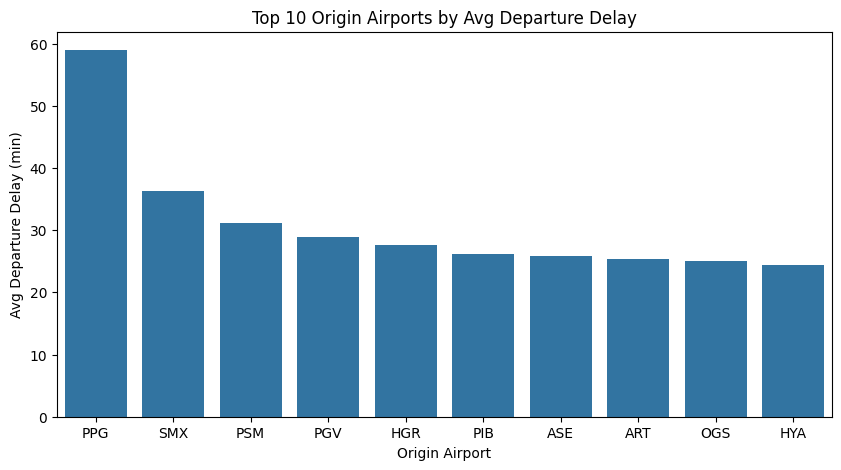

In [11]:
# 1. Top 10 busiest airports by average delay
top_airports = df.groupby('ORIGIN')['DEP_DELAY'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_airports.index, y=top_airports.values)
plt.title('Top 10 Origin Airports by Avg Departure Delay')
plt.xlabel('Origin Airport')
plt.ylabel('Avg Departure Delay (min)')
plt.show()

/var/folders/2x/7pj0tb_n6z54nzs162j3t19m0000gn/T/ipykernel_41484/1702999564.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='AIRLINE', y='DEP_DELAY', estimator='mean', ci=None, order=df['AIRLINE'].value_counts().index)


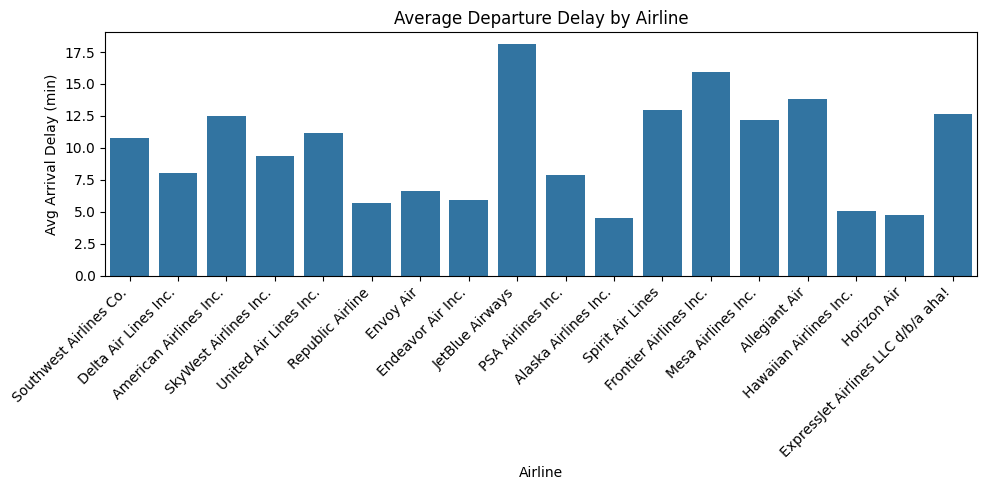

In [12]:
# 2. Average departure delay by airline
plt.figure(figsize=(10,5))
sns.barplot(data=df, x='AIRLINE', y='DEP_DELAY', estimator='mean', ci=None, order=df['AIRLINE'].value_counts().index)
plt.title('Average Departure Delay by Airline')
plt.xlabel('Airline')
plt.ylabel('Avg Arrival Delay (min)')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

### 2.4 Patterns

In [ ]:
import plotly.express as px

delay_causes = [
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT'
]

# Fill NaN values with 0 (just in case)
df[delay_causes] = df[delay_causes].fillna(0)

# Count how many delay causes were nonzero per flight
df['NUM_CAUSES'] = (df[delay_causes] > 0).sum(axis=1)

# Calculate distribution
cause_counts = df['NUM_CAUSES'].value_counts(normalize=True).sort_index()
cause_df = cause_counts.reset_index()
cause_df.columns = ['Num_Delay_Causes', 'Percentage']

# Plot as pie chart
fig = px.pie(
    cause_df, 
    values='Percentage', 
    names='Num_Delay_Causes',
    title='Distribution of Number of Nonzero Delay Causes per Flight',
    color_discrete_sequence=px.colors.sequential.RdBu
)
fig.update_traces(textinfo='percent+label')
fig.update_layout(title_x=0.5, width=800, height=500)
fig.show()


In [13]:
unique_airports = pd.unique(df['ORIGIN'].tolist() + df['DEST'].tolist())
print("Number of unique airports (ORIGIN + DEST):", len(unique_airports))
unique_airlines = df['AIRLINE'].nunique()
print("Number of unique airlines:", unique_airlines)

/var/folders/2x/7pj0tb_n6z54nzs162j3t19m0000gn/T/ipykernel_41484/188346982.py:1: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_airports = pd.unique(df['ORIGIN'].tolist() + df['DEST'].tolist())


Number of unique airports (ORIGIN + DEST): 380
Number of unique airlines: 18


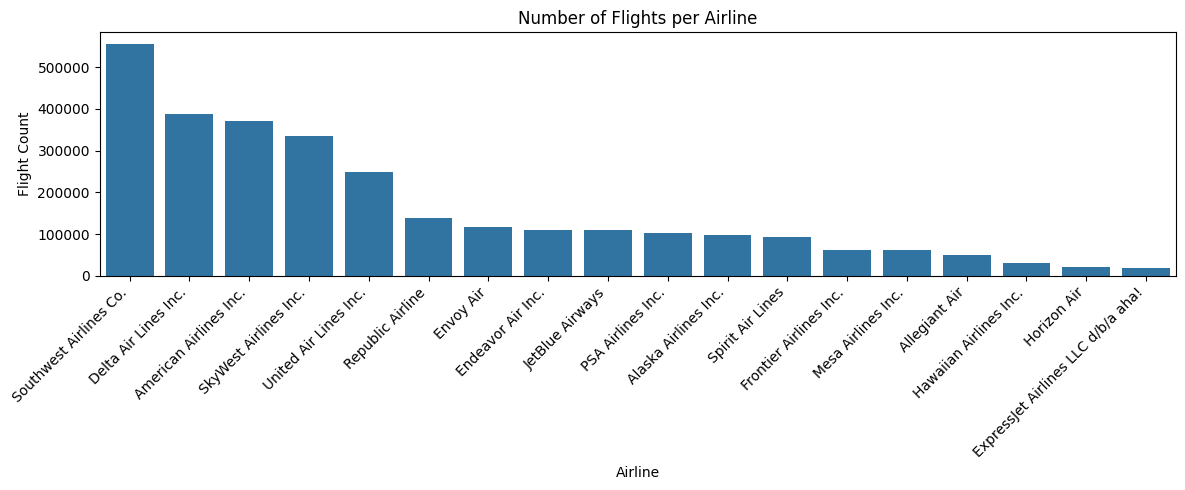

In [14]:
# 1. Number of flights per airline
airline_counts = df['AIRLINE'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12, 5))
sns.barplot(x=airline_counts.index, y=airline_counts.values)
plt.title('Number of Flights per Airline')
plt.xlabel('Airline')
plt.ylabel('Flight Count')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

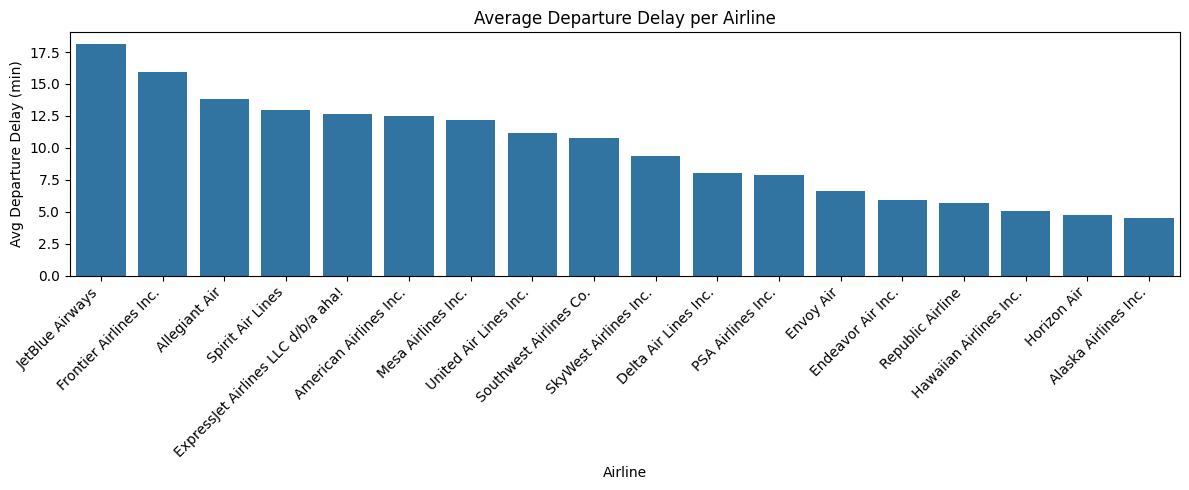

In [15]:
# 2. Average departure delay per airline
airline_avg_delay = df.groupby('AIRLINE')['DEP_DELAY'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 5))
sns.barplot(x=airline_avg_delay.index, y=airline_avg_delay.values)
plt.title('Average Departure Delay per Airline')
plt.xlabel('Airline')
plt.ylabel('Avg Departure Delay (min)')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

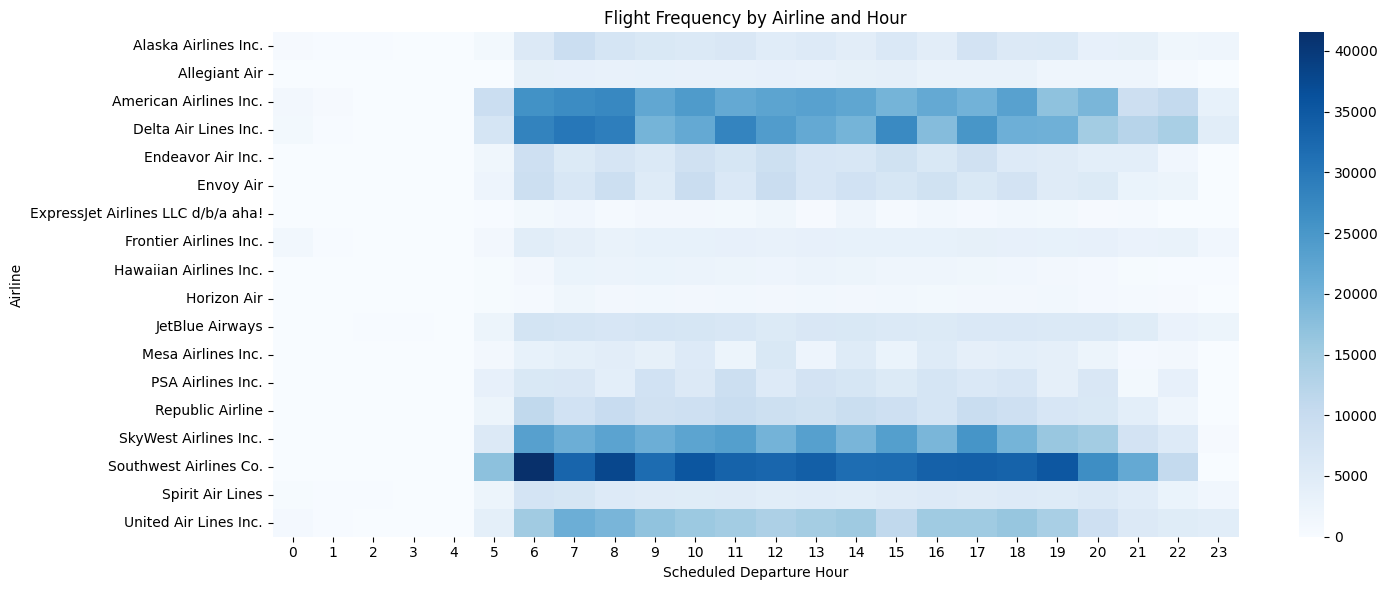

In [16]:
# 3. Heatmap of flight frequency by airline and hour
df['hour'] = (df['CRS_DEP_TIME'] // 100).astype('Int64')

airline_hour_counts = df.groupby(['AIRLINE', 'hour']).size().unstack().fillna(0)

plt.figure(figsize=(15, 6))
sns.heatmap(airline_hour_counts, cmap='Blues')
plt.title('Flight Frequency by Airline and Hour')
plt.xlabel('Scheduled Departure Hour')
plt.ylabel('Airline')
plt.tight_layout()
plt.show()

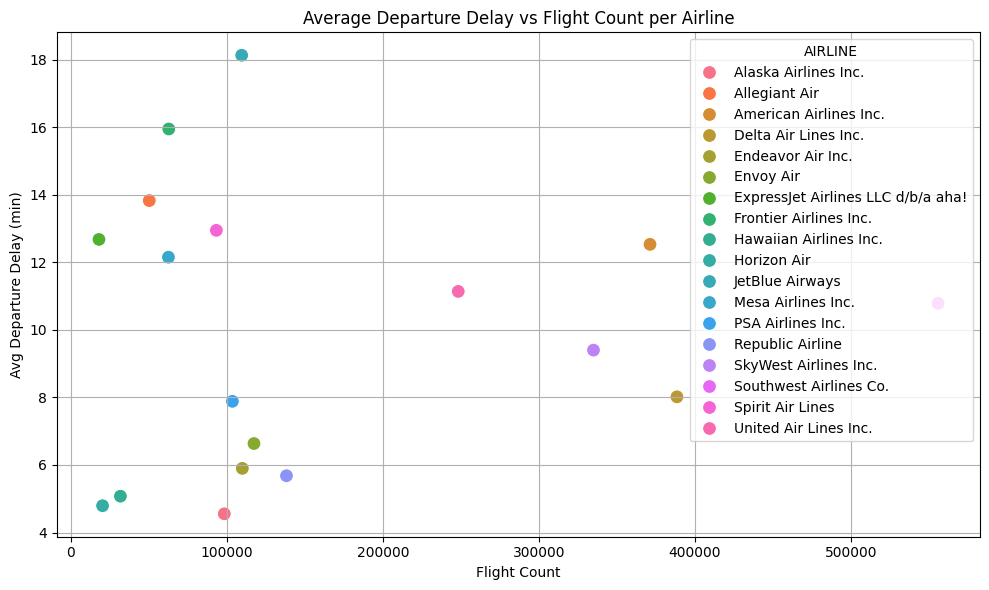

In [17]:
airline_stats = df.groupby('AIRLINE').agg({
    'DEP_DELAY': 'mean',
    'FL_NUMBER': 'count'
}).rename(columns={'DEP_DELAY': 'Avg_DEP_DELAY', 'FL_NUMBER': 'Flight_Count'}).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=airline_stats, x='Flight_Count', y='Avg_DEP_DELAY', hue='AIRLINE', s=100)
plt.title('Average Departure Delay vs Flight Count per Airline')
plt.xlabel('Flight Count')
plt.ylabel('Avg Departure Delay (min)')
plt.grid(True)
plt.tight_layout()
plt.show()

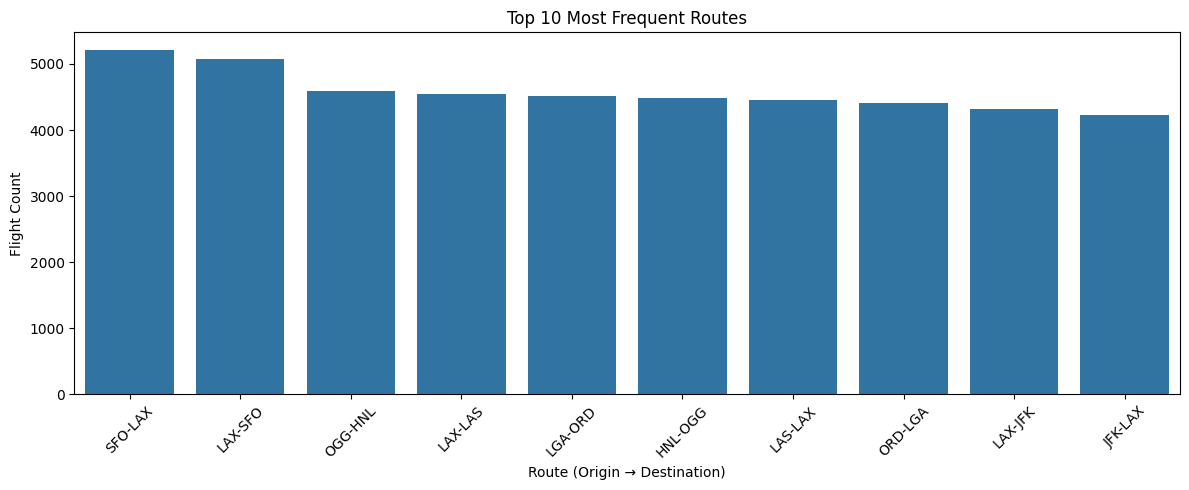

In [18]:
df['ROUTE'] = df['ORIGIN'] + '-' + df['DEST']
top_routes = df['ROUTE'].value_counts().head(10)

plt.figure(figsize=(12, 5))
sns.barplot(x=top_routes.index, y=top_routes.values)
plt.title('Top 10 Most Frequent Routes')
plt.xlabel('Route (Origin → Destination)')
plt.ylabel('Flight Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

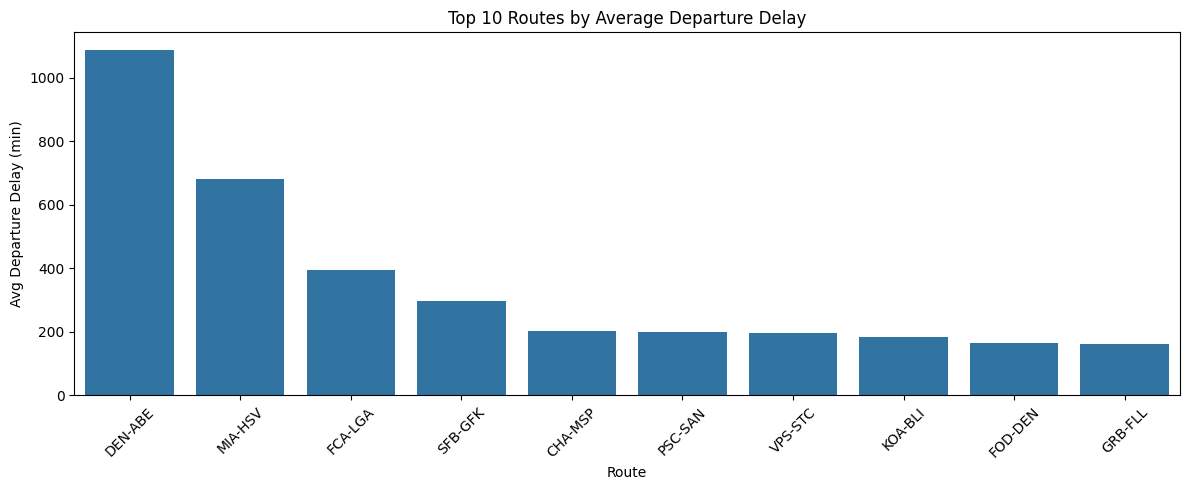

In [19]:
route_delay = df.groupby('ROUTE')['DEP_DELAY'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 5))
sns.barplot(x=route_delay.index, y=route_delay.values)
plt.title('Top 10 Routes by Average Departure Delay')
plt.xlabel('Route')
plt.ylabel('Avg Departure Delay (min)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


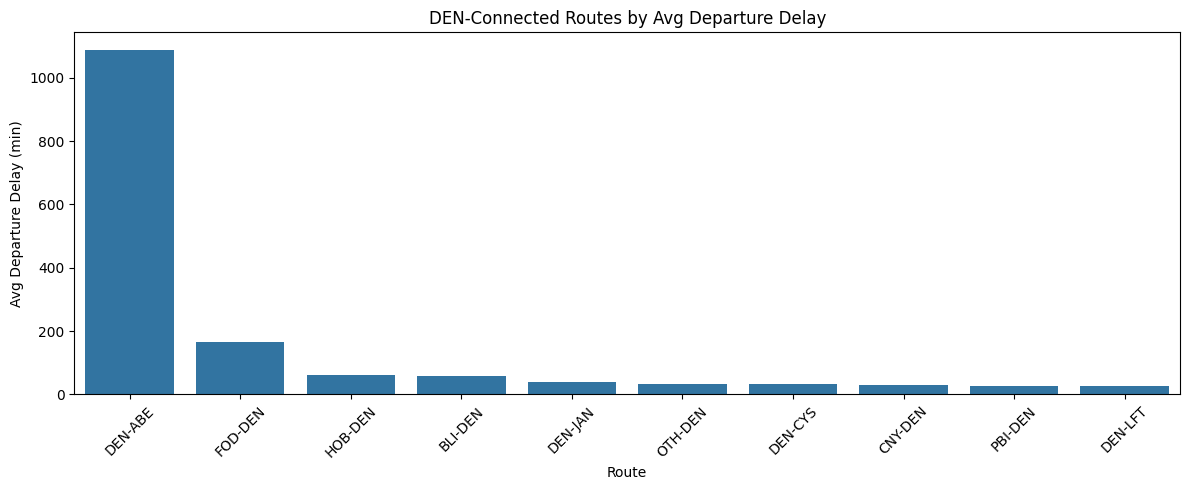

In [ ]:
# 1. Top 10 routes with the most delays
hub = 'DEN'  
atl_routes = df[(df['ORIGIN'] == hub) | (df['DEST'] == hub)].copy()
atl_routes['ROUTE'] = atl_routes['ORIGIN'] + '-' + atl_routes['DEST']

atl_route_delays = atl_routes.groupby('ROUTE')['DEP_DELAY'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 5))
sns.barplot(x=atl_route_delays.index, y=atl_route_delays.values)
plt.title(f'{hub}-Connected Routes by Avg Departure Delay')
plt.xlabel('Route')
plt.ylabel('Avg Departure Delay (min)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# Create route column
df['ROUTE'] = df['ORIGIN'] + '-' + df['DEST']

# Group by route: count and mean delay
route_stats = df.groupby('ROUTE').agg({
    'DEP_DELAY': 'mean',
    'FL_NUMBER': 'count'
}).rename(columns={
    'DEP_DELAY': 'Avg_DEP_DELAY',
    'FL_NUMBER': 'Flight_Count'
}).reset_index()

# Filter to only routes with at least 30 flights for clarity
route_stats = route_stats[route_stats['Flight_Count'] >= 30]

# Interactive scatter plot
fig = px.scatter(
    route_stats,
    x='Flight_Count',
    y='Avg_DEP_DELAY',
    hover_name='ROUTE',
    size='Flight_Count',
    color='Avg_DEP_DELAY',
    color_continuous_scale='RdBu',
    title='Route Popularity vs Average Departure Delay'
)

fig.update_layout(
    xaxis_title='Number of Flights',
    yaxis_title='Average Departure Delay (minutes)',
    font=dict(size=16),
    width=1000,
    height=600
)

fig.show()

/var/folders/2x/7pj0tb_n6z54nzs162j3t19m0000gn/T/ipykernel_41484/296331809.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




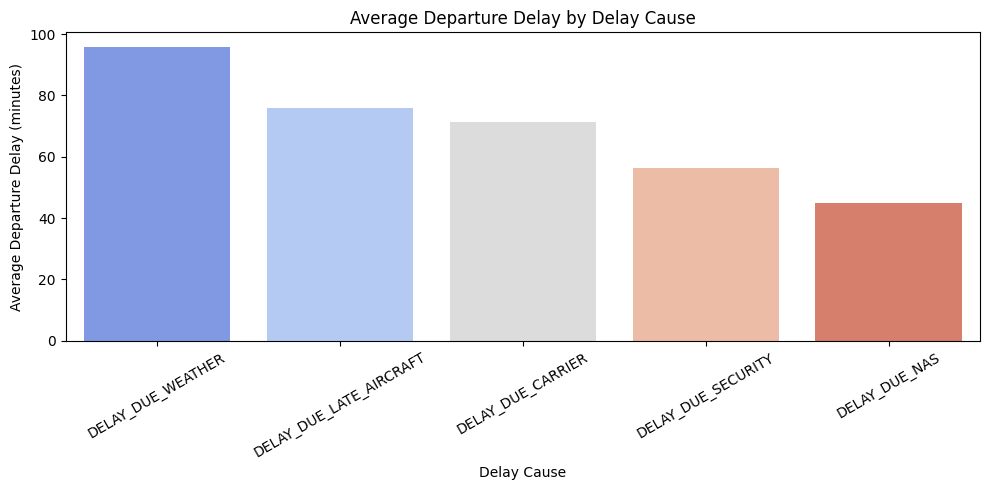

In [22]:
# List of delay causes
delay_causes = [
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT'
]

# fill NaN values with 0
df[delay_causes] = df[delay_causes].fillna(0)

# Calculate the total delay for each flight: when the cause is greater than 0
average_delays = {
    cause: df[df[cause] > 0]['DEP_DELAY'].mean()
    for cause in delay_causes
}

# Convert the dictionary to a DataFrame for better visualization
avg_delay_df = pd.DataFrame.from_dict(average_delays, orient='index', columns=['Avg_DEP_DELAY'])
avg_delay_df = avg_delay_df.sort_values(by='Avg_DEP_DELAY', ascending=False)


plt.figure(figsize=(10, 5))
sns.barplot(x=avg_delay_df.index, y=avg_delay_df['Avg_DEP_DELAY'], palette='coolwarm')
plt.title('Average Departure Delay by Delay Cause')
plt.xlabel('Delay Cause')
plt.ylabel('Average Departure Delay (minutes)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## 3. Feature Engineering

### 3.1 Time-based Features

In [ ]:
# Convert date column to datetime format
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], format='%Y-%m-%d')
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

# Remove canceled flights and rows with missing delay information
df = df[df['CANCELLED'] != 1]
df.dropna(subset=['DEP_DELAY', 'ARR_DELAY'], inplace=True)

# Create time-based features
df['hour'] = (df['CRS_DEP_TIME'] // 100).astype('Int64')
df['dayofweek'] = df['FL_DATE'].dt.dayofweek
df['month'] = df['FL_DATE'].dt.month
df['year'] = df['FL_DATE'].dt.year
df['day'] = df['FL_DATE'].dt.day


# Convert hhmm (e.g. 715) to minutes
def convert_hhmm_to_mins(hhmm_series):
    hhmm_str = hhmm_series.astype(str).str.zfill(4)
    return hhmm_str.str[:2].astype(int) * 60 + hhmm_str.str[2:].astype(int)

df['CRS_DEP_TIME_MINS'] = convert_hhmm_to_mins(df['CRS_DEP_TIME'])
df['CRS_ARR_TIME_MINS'] = convert_hhmm_to_mins(df['CRS_ARR_TIME'])
df['dep_hour'] = df['CRS_DEP_TIME_MINS'] // 60
df['dep_hour_sin'] = np.sin(2 * np.pi * df['dep_hour'] / 24)
df['dep_hour_cos'] = np.cos(2 * np.pi * df['dep_hour'] / 24)

### 3.2 Propagation-aware Features

In [34]:
df['ROUTE_KEY'] = df['AIRLINE'] + '_' + df['FL_NUMBER'].astype(str) + '_' + df['ORIGIN']
df.sort_values(by=['ROUTE_KEY', 'FL_DATE', 'CRS_DEP_TIME'], inplace=True)
df['PREV_FLIGHT_DELAY'] = df.groupby('ROUTE_KEY')['DEP_DELAY'].shift(1).fillna(0)

# === 연결편 기반 파생 변수 추가 ===

# 1. 도착공항 기준 연결키 생성
df['ARR_ROUTE_KEY'] = df['AIRLINE'] + '_' + df['DEST']

# 2. 연결편 시간 순 정렬
df.sort_values(by=['ARR_ROUTE_KEY', 'FL_DATE', 'CRS_DEP_TIME'], inplace=True)

# 3. 다음 항공편의 출발 지연 시간
df['NEXT_FLIGHT_DEP_DELAY'] = df.groupby('ARR_ROUTE_KEY')['DEP_DELAY'].shift(-1)

# 4. 첫 행/마지막 연결편 등 누락 처리
df['NEXT_FLIGHT_DEP_DELAY'] = df['NEXT_FLIGHT_DEP_DELAY'].fillna(0)

# 5. 연결편이 지연되었는지 여부 (15분 초과 기준)
df['NEXT_FLIGHT_WAS_DELAYED'] = (df['NEXT_FLIGHT_DEP_DELAY'] > 15).astype(int)

In [ ]:
# Create centrality feature
import networkx as nx

# 1. 방향 그래프 생성
G = nx.from_pandas_edgelist(df, source='ORIGIN', target='DEST', create_using=nx.DiGraph())

# 2. 중심성 계산
deg_centrality = nx.degree_centrality(G)
btw_centrality = nx.betweenness_centrality(G)
eig_centrality = nx.eigenvector_centrality(G)
cls_centrality = nx.closeness_centrality(G)

# 3. DataFrame으로 변환
centrality_df = pd.DataFrame({
    'AIRPORT': list(deg_centrality.keys()),
    'DEGREE_CENTRALITY': list(deg_centrality.values()),
    'BETWEENNESS_CENTRALITY': list(btw_centrality.values()),
    'EIGENVECTOR_CENTRALITY': list(eig_centrality.values()),
    'CLOSENESS_CENTRALITY': list(cls_centrality.values())
})

# 4. 병합
df = df.merge(centrality_df, left_on='ORIGIN', right_on='AIRPORT', how='left')
df = df.merge(centrality_df, left_on='DEST', right_on='AIRPORT', suffixes=('_ORIGIN', '_DEST'), how='left')
df.drop(columns=['AIRPORT_ORIGIN', 'AIRPORT_DEST'], inplace=True)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


### 3.3 Hub Airport Feature

/var/folders/2x/7pj0tb_n6z54nzs162j3t19m0000gn/T/ipykernel_41484/2750244272.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




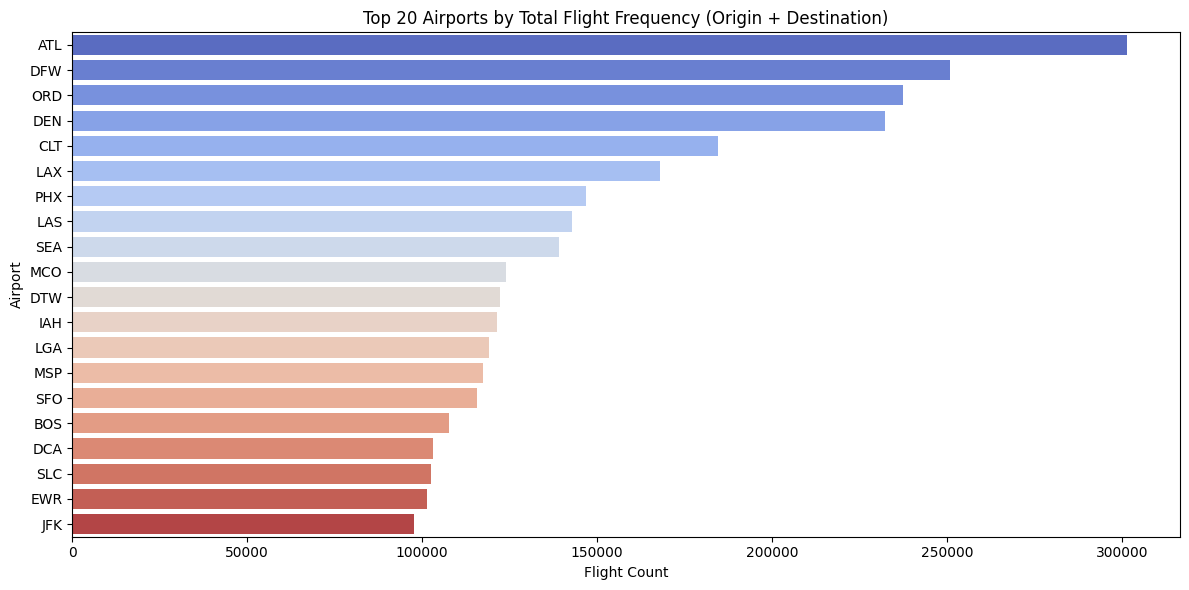

In [35]:
# Total Flight Frequency (Origin + Destination)
origin_counts = df['ORIGIN'].value_counts()
dest_counts = df['DEST'].value_counts()
airport_total = origin_counts.add(dest_counts, fill_value=0).sort_values(ascending=False)

# Top 20
plt.figure(figsize=(12,6))
sns.barplot(x=airport_total.head(20).values, y=airport_total.head(20).index, palette="coolwarm")
plt.title("Top 20 Airports by Total Flight Frequency (Origin + Destination)")
plt.xlabel("Flight Count")
plt.ylabel("Airport")
plt.tight_layout()
plt.show()

In [36]:
major_hubs = ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'PHX', 'LAS', 'SEA', 'MCO']
df['ORIGIN_IS_HUB'] = df['ORIGIN'].isin(major_hubs).astype(int)
df['DEST_IS_HUB'] = df['DEST'].isin(major_hubs).astype(int)
df['HUB_TO_HUB'] = ((df['ORIGIN_IS_HUB'] == 1) & (df['DEST_IS_HUB'] == 1)).astype(int)

# Create connectivity features
origin_connectivity = df.groupby('ORIGIN')['DEST'].nunique()
df['ORIGIN_CONNECTIVITY'] = df['ORIGIN'].map(origin_connectivity)

### 3.4 Feature Importance via Correlation Analysis

/Users/jh/anaconda3/envs/a_env/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning:

invalid value encountered in divide

/Users/jh/anaconda3/envs/a_env/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning:

invalid value encountered in divide

/var/folders/2x/7pj0tb_n6z54nzs162j3t19m0000gn/T/ipykernel_41484/448570435.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




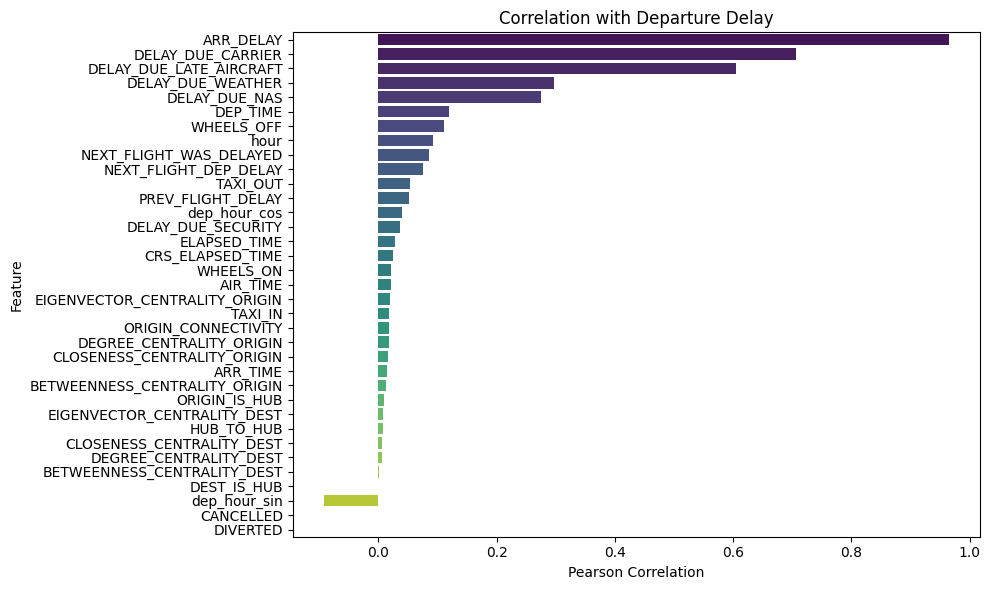

In [37]:
df['DISTANCE'] = df['DISTANCE'].astype(int)

# Calculate Pearson Correlation on just the non-categorical attributes, since Pearson Correlation is invalid for categorical attributes
numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(columns=['DEP_DELAY']).columns
correlation_matrix = df[numeric_features].corrwith(df['DEP_DELAY']).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_matrix.values, y=correlation_matrix.index, palette="viridis")
plt.title('Correlation with Departure Delay')
plt.xlabel('Pearson Correlation')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [38]:
from datetime import datetime
df.to_csv(f"cleaned_flight_data.csv", index=False)

In [43]:
file_path = 'cleaned_flight_data.csv'
df = pd.read_csv(file_path)
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], errors='coerce')

In [44]:
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,BETWEENNESS_CENTRALITY_ORIGIN,EIGENVECTOR_CENTRALITY_ORIGIN,CLOSENESS_CENTRALITY_ORIGIN,DEGREE_CENTRALITY_DEST,BETWEENNESS_CENTRALITY_DEST,EIGENVECTOR_CENTRALITY_DEST,CLOSENESS_CENTRALITY_DEST,ARR_ROUTE_KEY,NEXT_FLIGHT_DEP_DELAY,NEXT_FLIGHT_WAS_DELAYED
0,2019-01-08,Alaska Airlines Inc.,Alaska Airlines Inc.: AS,AS,19930,794,SEA,"Seattle, WA",ABQ,"Albuquerque, NM",...,0.055965,0.121668,0.568216,0.14248,0.00019,0.055646,0.498029,Alaska Airlines Inc._ABQ,-13.0,0
1,2019-01-30,Alaska Airlines Inc.,Alaska Airlines Inc.: AS,AS,19930,794,SEA,"Seattle, WA",ABQ,"Albuquerque, NM",...,0.055965,0.121668,0.568216,0.14248,0.00019,0.055646,0.498029,Alaska Airlines Inc._ABQ,-9.0,0
2,2019-02-06,Alaska Airlines Inc.,Alaska Airlines Inc.: AS,AS,19930,794,SEA,"Seattle, WA",ABQ,"Albuquerque, NM",...,0.055965,0.121668,0.568216,0.14248,0.00019,0.055646,0.498029,Alaska Airlines Inc._ABQ,-9.0,0
3,2019-03-10,Alaska Airlines Inc.,Alaska Airlines Inc.: AS,AS,19930,1794,SEA,"Seattle, WA",ABQ,"Albuquerque, NM",...,0.055965,0.121668,0.568216,0.14248,0.00019,0.055646,0.498029,Alaska Airlines Inc._ABQ,-2.0,0
4,2019-03-13,Alaska Airlines Inc.,Alaska Airlines Inc.: AS,AS,19930,1794,SEA,"Seattle, WA",ABQ,"Albuquerque, NM",...,0.055965,0.121668,0.568216,0.14248,0.00019,0.055646,0.498029,Alaska Airlines Inc._ABQ,1.0,0


## 4. Categorical Encoding

### 4.1 Label Encoding

In [ ]:
df_label = df.copy()

# Label Encoding for categorical features
categorical_cols = ['AIRLINE', 'ORIGIN', 'DEST']

# Airport encoder
airport_encoder = LabelEncoder()
all_airports = pd.concat([df_label['ORIGIN'], df_label['DEST']]).unique()
airport_encoder.fit(all_airports)

df_label['ORIGIN_ENC'] = airport_encoder.transform(df_label['ORIGIN'])
df_label['DEST_ENC'] = airport_encoder.transform(df_label['DEST'])

# Airline encoder
airline_encoder = LabelEncoder()
df_label['AIRLINE_ENC'] = airline_encoder.fit_transform(df_label['AIRLINE'])

label_features = [
    'hour', 'dayofweek', 'month', 'DISTANCE',
    'CRS_DEP_TIME_MINS', 'CRS_ARR_TIME_MINS', 'dep_hour_sin', 'dep_hour_cos',
    'PREV_FLIGHT_DELAY', 'NEXT_FLIGHT_DEP_DELAY', 'NEXT_FLIGHT_WAS_DELAYED',
    'ORIGIN_ENC', 'DEST_ENC', 'AIRLINE_ENC',
    'ORIGIN_IS_HUB', 'DEST_IS_HUB', 'HUB_TO_HUB',
    'BETWEENNESS_CENTRALITY_ORIGIN', 'EIGENVECTOR_CENTRALITY_ORIGIN', 'CLOSENESS_CENTRALITY_ORIGIN',
    'DEGREE_CENTRALITY_DEST', 'BETWEENNESS_CENTRALITY_DEST', 'EIGENVECTOR_CENTRALITY_DEST', 'CLOSENESS_CENTRALITY_DEST'
]

X_label = df_label[label_features]
y_label = df_label['DEP_DELAY']

# 저장
X_label.to_csv("X_label_encoded.csv", index=False)
y_label.to_csv("y_label_encoded.csv", index=False)


### 4.2 One-hot Encoding

In [ ]:
df_onehot = df.copy()

if 'ROUTE' in df_onehot.columns:
    df_onehot.drop(columns=['ROUTE'], inplace=True)

onehot_features = [
    'hour', 'dayofweek', 'month', 'DISTANCE',
    'CRS_DEP_TIME_MINS', 'CRS_ARR_TIME_MINS', 'dep_hour_sin', 'dep_hour_cos',
    'PREV_FLIGHT_DELAY', 'NEXT_FLIGHT_DEP_DELAY', 'NEXT_FLIGHT_WAS_DELAYED',
    'AIRLINE', 'ORIGIN', 'DEST',
    'ORIGIN_IS_HUB', 'DEST_IS_HUB', 'HUB_TO_HUB',
    'BETWEENNESS_CENTRALITY_ORIGIN', 'EIGENVECTOR_CENTRALITY_ORIGIN', 'CLOSENESS_CENTRALITY_ORIGIN',
    'DEGREE_CENTRALITY_DEST', 'BETWEENNESS_CENTRALITY_DEST', 'EIGENVECTOR_CENTRALITY_DEST', 'CLOSENESS_CENTRALITY_DEST'
]

X_onehot_raw = df_onehot[onehot_features]
y_onehot = df_onehot['DEP_DELAY']

# One-hot 
X_onehot = pd.get_dummies(X_onehot_raw, columns=['AIRLINE', 'ORIGIN', 'DEST'], drop_first=True)

X_onehot.to_csv("X_onehot_encoded.csv", index=False)
y_onehot.to_csv("y_onehot_encoded.csv", index=False)


In [50]:
X_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2913802 entries, 0 to 2913801
Columns: 796 entries, hour to DEST_YUM
dtypes: bool(775), float64(11), int64(10)
memory usage: 2.6 GB


In [ ]:
X_label.info()